In [3]:
import sys
sys.path.append('../..')
from torchdyn.models import *; from torchdyn.datasets import *

In [4]:
device = torch.device('cuda')

# Latent Neural ODEs

In [18]:
class HybridNeuralDE(nn.Module):
    def __init__(self, jump, flow, out, hidden_size, last_output=True, reverse=False):
        super().__init__()
        self.flow, self.jump, self.out = flow, jump, out
        self.hidden_size, self.last_output = hidden_size, last_output
        self.reverse = reverse
        
    def forward(self, x):
        h, c = self._init_latent(x[0])
        Y = []
        if self.reverse: x_t = x_t.flip(0)
        for i, x_t in enumerate(x): 
            h, c = self.jump(x_t, (h, c))
            h = self.flow(h)
            if self.out: out = self.out(h) 
            else: out = h
            Y.append(out[None])
        Y = torch.cat(Y)
        return Y[-1] if self.last_output else Y
        
    def _init_latent(self, x):
        h = torch.zeros((x.shape[0], self.hidden_size)).to(x.device)
        c = torch.zeros((x.shape[0], self.hidden_size)).to(x.device)
        return h, c

In [25]:
class LatentNeuralDE(nn.Module):
    def __init__(self, encoder, decoder, out):
        super().__init__()
        self.encoder, self.decoder, self.out = encoder, decoder, out
        
    def forward(self, x, s_span):
      
        z = self.encoder(x)
 
        z, qz0_mean, qz0_logvar = self.reparametrize(z)
        
        decoded_traj = self.decoder.trajectory(z, s_span)
        
        #outs = []
        #for el in decoded_traj:
        #    outs += [self.out(el)[None]]
        return decoded_traj, qz0_mean, qz0_logvar
    
    def reparametrize(self, z):
        dim = z.shape[1] // 2
        qz0_mean, qz0_logvar = z[:, :dim], z[:, dim:]
        epsilon = torch.randn(qz0_mean.size()).to(z)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        return z0, qz0_mean, qz0_logvar

In [31]:
# encoder
jump = nn.LSTMCell(input_size=2, hidden_size=16)
f = nn.Sequential(nn.Linear(16, 64),
                  nn.ELU(),
                  nn.Linear(64, 64),
                  nn.ELU(),
                  nn.Linear(64, 16))

flow = NeuralDE(f, solver='dopri5', atol=1e-5, rtol=1e-5, sensitivity='autograd')
out = nn.Sequential(nn.Linear(16, 64), nn.ReLU(), nn.Linear(64, 8))
encoder = HybridNeuralDE(jump, flow, out, 16)
  
# decoder
f = Stable(nn.Sequential(nn.Linear(4, 64),
                         nn.Softplus(),
                         nn.Linear(64, 64),
                         nn.Tanh(),
                         nn.Linear(64, 1)))
          
decoder = NeuralDE(f, solver='dopri5', atol=1e-5, rtol=1e-5, sensitivity='autograd')

# out 
out = nn.Sequential(nn.Linear(4, 64), nn.ReLU(), nn.Linear(64, 2))
model = LatentNeuralDE(encoder, decoder, out).to(device)

In [27]:
data = torch.load('data/data_06_1_14')
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(data.transpose(0, 1))
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [32]:
from torch.distributions import Independent, Normal

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
latent_dim = 4
noise_std = 0.1
EPOCHS = 90

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch}')
    iterator = iter(loader)
    for i, x in enumerate(iterator):
        x = x[0].to(device)
        batch_size = x.shape[0] # 'B, L, D'
        input_x = x.transpose(0, 1) # 'L, B, D'

        pred_x, qz0_mean, qz0_logvar = model(input_x[:20], torch.linspace(0, 5, 50))
        pred_x = pred_x.transpose(0, 1)[:, :, :2] # 'B, L, D'
        
        # TO DO: mask dimensions of the joint distribution where the observation is missing
        mask = torch.zeros(batch_size, x.shape[1]).to(device)
        for k, el in enumerate(x):
            mask[k] = (el!=0)[:, 0]
    
        # logp under gaussian prior 
        noise_std_ = torch.zeros_like(pred_x.reshape(batch_size, -1)) + noise_std # 'B, L, D'
        dist_x = Independent(Normal(x.reshape(batch_size, -1), noise_std_), 1)
        
        # zero missing predictions so that logpx is artificially maximized and gradient is 0
        pred_x = pred_x * mask[:, :, None]
        logpx = dist_x.log_prob(pred_x.reshape(batch_size, -1))

        # kl between variational q and prior
        pz0_mean = pz0_logvar = torch.zeros(qz0_mean.size()).to(device) # `B, latent_dim // 2`
        p = Independent(Normal(pz0_mean, torch.exp(pz0_logvar)), 1) 
        q = Independent(Normal(qz0_mean, torch.exp(qz0_logvar)), 1)
        kl = torch.distributions.kl_divergence(q, p)

        # minimize nllikelihood while constraining variational dist and prior
        loss = torch.mean(-logpx + kl, dim=0)
        print(f'\r{loss}, {i}', end='')
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        if i % 10 == 0:
            with torch.no_grad():
                plot(input_x, model, i)
    print('\n')

Epoch: 0
-76.06438446044922, 460

Epoch: 1
-92.68257141113281, 46

Epoch: 2
-96.56370544433594, 468

Epoch: 3
-98.14824676513672, 469

Epoch: 4
-99.27310943603516, 465

Epoch: 5
-91.5374984741211, 4653

Epoch: 6
-100.62860870361328, 46

Epoch: 7
-99.64144897460938, 467

Epoch: 8
-98.69473266601562, 464

Epoch: 9
-97.39350891113281, 463

Epoch: 10
-99.86186218261719, 466

Epoch: 11
-101.08430480957031, 46

Epoch: 12
-99.68380737304688, 46

Epoch: 13
-96.52088165283203, 464

Epoch: 14
-96.86026763916016, 468

Epoch: 15
-100.80350494384766, 46

Epoch: 16
-103.34169006347656, 46

Epoch: 17
-96.04109954833984, 464

Epoch: 18
-91.31511688232422, 461

Epoch: 19
-93.10462188720703, 464

Epoch: 20
-96.02243041992188, 461

Epoch: 21
-94.34362030029297, 463

Epoch: 22
-95.84355926513672, 463

Epoch: 23
-102.26905059814453, 46

Epoch: 24
-95.9493179321289, 4654

Epoch: 25
-101.87614440917969, 46

Epoch: 26
-97.35346984863281, 462

Epoch: 27
-91.77497863769531, 469

Epoch: 28
-99.6746597290039, 465

In [363]:
torch.save(model.state_dict(), 'model_no_readout')

In [29]:
def plot(input_x, model, i):
    import matplotlib.pyplot as plt
    pred_x, qz0_mean, qz0_logvar = model(input_x, torch.linspace(0, 5, 50))
    pred_x = pred_x.transpose(0, 1)
    pred_x = pred_x.detach().cpu()

    plt.figure(figsize=(10, 6))
    for k in range(10):
        plt.scatter(pred_x[k,:,0], pred_x[k,:,1], c='r', s=8, alpha=0.4)

        # base data
        a = input_x.detach().cpu()
        plt.scatter(a[:,k,0], a[:,k,1], c='b',  s=8, alpha=0.4)

    plt.title('Red: samples from posterior. Blue: dataset')
    plt.savefig(f'media/{i}')
    plt.close()

No we identify time series of specific `m` "types"

In [365]:
n = 30840 // 3
m1, m2, m3 = data[:, :n, :], data[:, n:2*n, :], data[:, 2*n:3*n, :]

In [366]:
input_x = m3
pred_x, qz0_mean, qz0_logvar = model(input_x[:, :100].to(device), torch.linspace(0, 5, 50))
print(pred_x.shape)
pred_x = pred_x.transpose(0, 1)
pred_x = pred_x.detach().cpu()

RuntimeError: CUDA error: invalid configuration argument

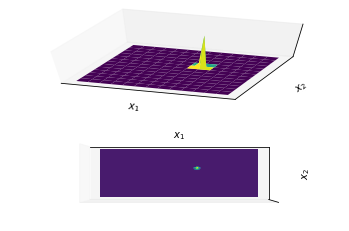

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N


# Our 2-dimensional distribution will be over variables X and Y
N = 40
X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu = qz0_mean[2][:2].detach().cpu().numpy(); Sigma = torch.exp(qz0_logvar[2][:2]).diag_embed().detach().cpu().numpy()
# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1,projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(2,1,2,projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()

In [302]:
qz0_mean.shape

torch.Size([100, 4])

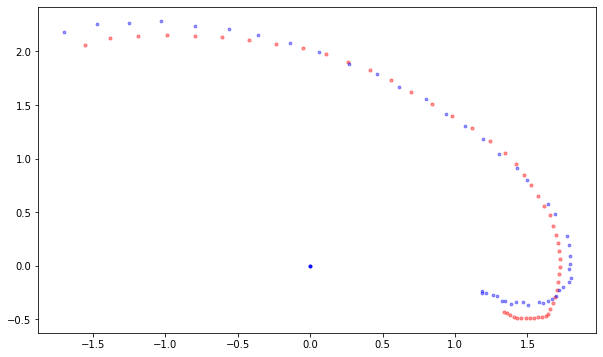

In [300]:
k = 4
plt.figure(figsize=(10, 6))
plt.scatter(pred_x[k,:,0], pred_x[k,:,1], c='r', s=10, alpha=0.4)

a = input_x.detach().cpu()
plt.scatter(a[:,k,0], a[:,k,1], c='b',  s=8, alpha=0.4)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

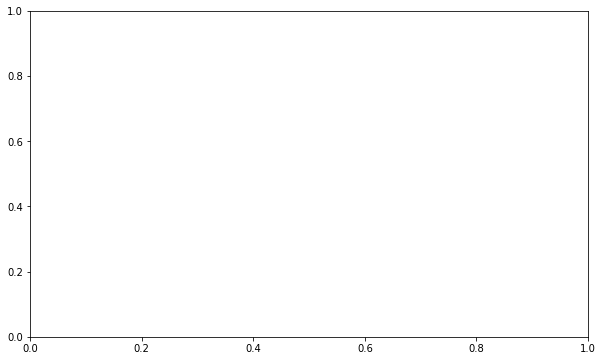

In [265]:
k = 8

plt.figure(figsize=(10, 6))
plt.scatter(pred_x[k,:,0], pred_x[k,:,1], c='r', s=10, alpha=0.4)

a = input_x.detach().cpu()
plt.scatter(a[:,k,0], a[:,k,1], c='b',  s=8, alpha=0.4)

Text(0.5, 1.0, 'Red: samples from posterior. Blue: dataset')

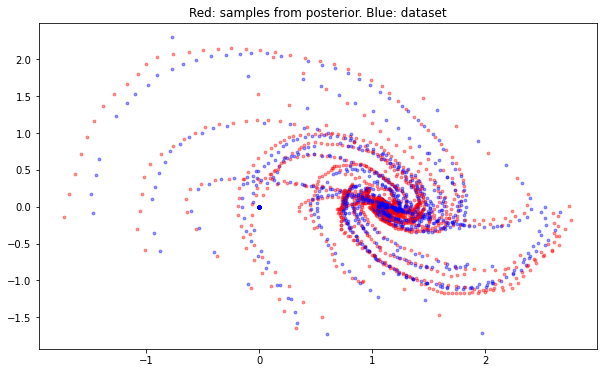

In [266]:
pred_x, qz0_mean, qz0_logvar = model(input_x, torch.linspace(0, 5, 50))
pred_x = pred_x.transpose(0, 1)
pred_x = pred_x.detach().cpu()

plt.figure(figsize=(10, 6))
for k in range(30):
    plt.scatter(pred_x[k,:,0], pred_x[k,:,1], c='r', s=8, alpha=0.4)

    # base data
    a = input_x.detach().cpu()
    plt.scatter(a[:,k,0], a[:,k,1], c='b',  s=8, alpha=0.4)

plt.title('Red: samples from posterior. Blue: dataset')

In [14]:
s_span = torch.linspace(0, 5, 100)
z = model.encoder(samp_traj[:, :1])
z, qz0_mean, qz0_logvar = model.reparametrize(z)
decoded_traj = model.decoder.trajectory(z, s_span)

In [21]:
z.shape

torch.Size([1, 4])

In [20]:
n_grid =  50
x = torch.linspace(-1, 1, n_grid)
x1, x2 = torch.meshgrid(x, x)

x = torch.cat([x1.reshape(-1, 1), x2.reshape(-1, 1)], 1).to(device)
x = x.requires_grad_(True)
eps = model.decoder.defunc.m.net(x)

RuntimeError: size mismatch, m1: [2500 x 2], m2: [4 x 32] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [ ]:
eps_l, grad_l = [], []
for f in fs:


    grad = torch.autograd.grad(eps.sum(), x)[0]
    grad = grad.reshape(x1.shape[0], x2.shape[0], 2).detach().cpu()
    grad = torch.norm(grad, p=2, dim=2)
    eps = eps.reshape(x1.shape[0], x2.shape[0]).detach().cpu()
    
    eps_l += [eps]
    grad_l += [grad]